# Testings for PlesioGeostroPy

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from scipy import special as specfun
import matplotlib.pyplot as plt

from pg_utils.pg_model import base, core

import os, perfplot
plt.style.use("default")

**Regularity tests** are now removed from this notebook.
For further regularity conditions and tests, see [Demo_Regularity.ipynb](Demo_Regularity.ipynb)

---
## Jacobi polynomial evaluation

In [2]:
from scipy.special import eval_jacobi, roots_jacobi
from pg_utils.numerics.special import eval_jacobi_recur, eval_jacobi_nrange, eval_jacobi_recur_Nmax

### Precision test

In [15]:
n_range = np.arange(-2, 101)
alpha, beta = 1/2, -1/2
xi, wt = roots_jacobi(101, alpha, beta)
N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [16]:
Jacobi_val_scipy = eval_jacobi(N_mesh, alpha, beta, X_mesh)
Jacobi_val_recur = eval_jacobi_recur(N_mesh, alpha, beta, X_mesh)

Compare the results

C:\Users\gentle\AppData\Local\Temp\ipykernel_17356\3781117974.py:6: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.log10(relative_err), *cmap_range))


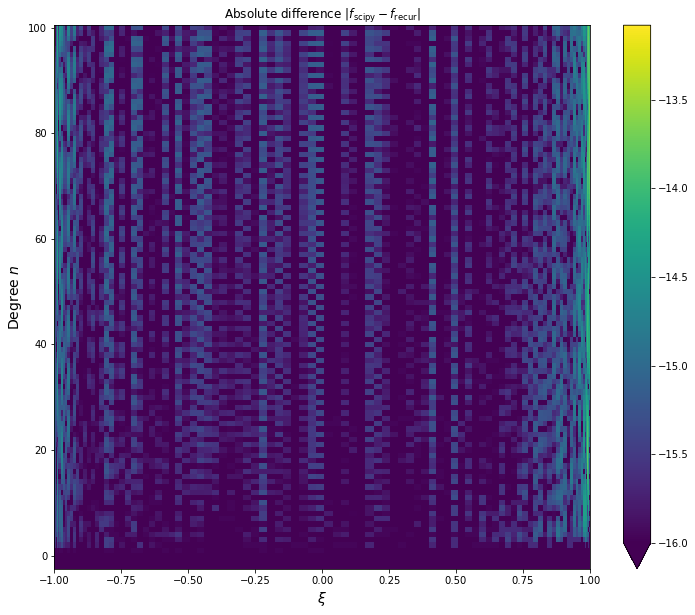

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

cmap_range = [-16, None]

relative_err = np.abs(Jacobi_val_scipy - Jacobi_val_recur)
im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.log10(relative_err), *cmap_range))
ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel("Degree $n$", fontsize=14)
ax.set_title(r"Absolute difference $|f_{\mathrm{scipy}} - f_{\mathrm{recur}}|$")
plt.colorbar(im, extend="min")

plt.show()

$L_2$-error

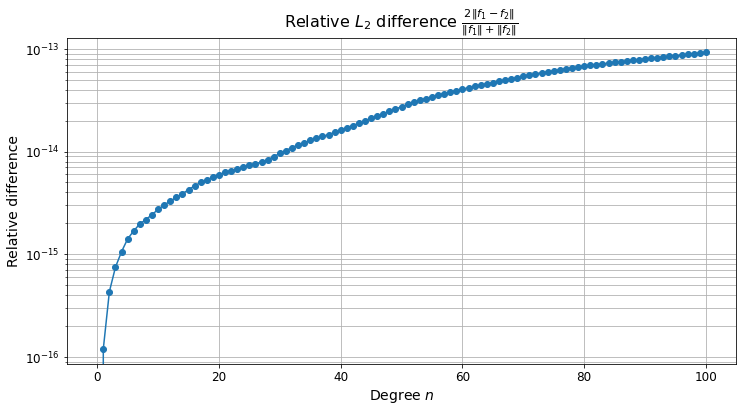

In [18]:
norm_Jacobi_scipy = np.sum(Jacobi_val_scipy**2*wt, axis=-1)
norm_Jacobi_recur = np.sum(Jacobi_val_recur**2*wt, axis=-1)
norm_diff = np.sum((Jacobi_val_scipy - Jacobi_val_recur)**2*wt, axis=-1)

fig, ax = plt.subplots(figsize=(12, 6))

relative_err = np.sqrt(norm_diff[n_range >= 0])/((np.sqrt(norm_Jacobi_recur[n_range >= 0]) + np.sqrt(norm_Jacobi_scipy[n_range >= 0]))/2)
ax.semilogy(n_range[n_range >= 0], relative_err, 'o-')
ax.set_xlabel("Degree $n$", fontsize=14)
ax.set_ylabel("Relative difference", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title(r"Relative $L_2$ difference $\frac{2\Vert f_1 - f_2 \Vert}{\Vert f_1\Vert + \Vert f_2\Vert}$", fontsize=16)
ax.grid(which="both")

plt.show()

It therefore seems that what is computed using recurrence relation and what is computed using the library function is different by at most $10^{-13}$, both in the absolute sense and in the relative sense.

It is also important to understand that `scipy.special.eval_jacobi` is not precise up to the last digit of machine precision! The following example shows you can easily find $10^{-14}$ absolute error near the edge of the interval.

In [19]:
print(eval_jacobi(50, 0.5, -0.5, -0.99988))

import mpmath as mp
with mp.workprec(112):
    print(mp.jacobi(50, 0.5, -0.5, -0.99988))

0.056451040336358276
0.0564510403363336568288337047684404


Therefore, the fact that recurrence relation implementation differs from the `scipy.special.eval_jacobi` calculation does not mean that the former is more erroneous. With multi-precision calculation below, one can actually show that the two have similar error level.

### Efficiency test

Define functions for testing

In [20]:
npts_eval = 100

def params_setup(Nmax):
    n_range = np.arange(Nmax + 1)
    alpha, beta = 1/2, -1/2
    xi, _ = roots_jacobi(npts_eval, alpha, beta)
    N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
    return n_range, xi, N_mesh, X_mesh, alpha, beta

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [25]:
benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi(N_mesh, alpha, beta, X_mesh),
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_recur(N_mesh, alpha, beta, X_mesh)
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_nrange(n_range[0], n_range[-1], alpha, beta, xi)
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_to_Nmax(n_range[-1], alpha, beta, xi)
    ],
    labels=["scipy", "recurrence"],
    n_range=[int(10**(N/5)) for N in range(0, 16)],
    show_progress=False
)

Output()

Compare the results

In [26]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ scipy                  ┃ recurrence             ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1    │ 2.4000000000000003e-06 │ 2.7300000000000003e-05 │
│ 1    │ 2.4000000000000003e-06 │ 2.71e-05               │
│ 2    │ 4.2000000000000004e-06 │ 6.63e-05               │
│ 3    │ 7.6e-06                │ 7.43e-05               │
│ 6    │ 1.77e-05               │ 8.960000000000001e-05  │
│ 10   │ 4.1500000000000006e-05 │ 0.00010960000000000001 │
│ 15   │ 8.55e-05               │ 0.0001327              │
│ 25   │ 0.00024170000000000002 │ 0.0001818              │
│ 39   │ 0.0006177              │ 0.0002474              │
│ 63   │ 0.0015596000000000002  │ 0.00035850000000000004 │
│ 100  │ 0.0036339000000000002  │ 0.0005327              │
│ 158  │ 0.008407300000000001   │ 0.0008031000000000001  │
│ 251  │ 0.01949                │ 0.0012394              │
│ 398  │ 0.0466883              │ 0.0019453              │
│ 630  │ 0.1138726              │ 0.0030329000000000003  │
│ 1000 │ 0.28255650000000004    │ 0.0054135              │
└──────┴────────────────────────┴────────────────────────┘

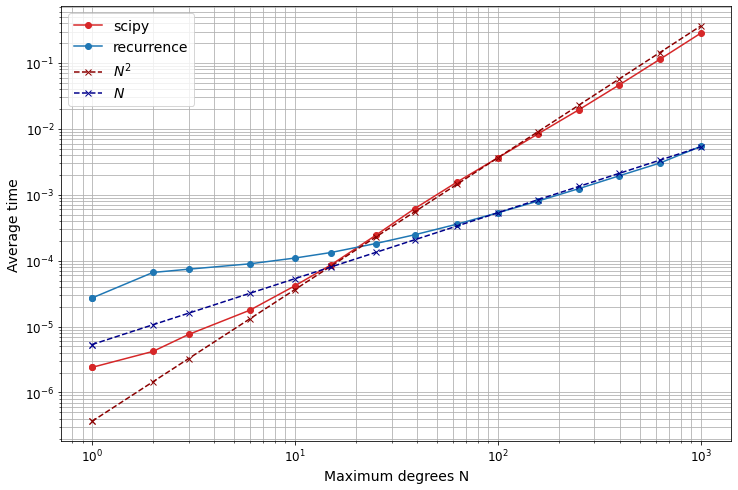

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Scalings for two approaches
- Naively calling `scipy.special.eval_jacobi` on an array of degrees up to degree N gives a complexity of $O(N^2)$.
- Using recurrence relations to generate values for the same array of degrees gives a complexity of $O(N)$.

Naturally, `scipy` functions are better optimized and this particular function is computed with C functions.
A factor of $\sim 10$ exists between the two implementations at low degrees, and the current crossing point of the two complexity curves is located at $N\approx 20$.

Profiler

In [33]:
%lprun -f eval_jacobi_recur_Nmax [eval_jacobi_nrange(0, 100, alpha, beta, xi) for i in range(500)]

Timer unit: 1e-07 s

Total time: 0.337433 s
File: C:\Users\gentle\Documents\Projects\PG-Assim\pg_utils\numerics\special.py
Function: eval_jacobi_recur_Nmax at line 229

Line #      Hits         Time  Per Hit   % Time  Line Contents
   229                                           def eval_jacobi_recur_Nmax(Nmax: int, alpha: float, beta: float, 
   230                                               z: np.ndarray) -> np.ndarray:
   231                                               """Evaluate Jacobi polynomials with recurrence relation up to a degree
   232                                               
   233                                               This functions generates values for Jacobi polynomials from degree 0
   234                                               up to a specified degree, using recurrence relations.
   235                                               
   236                                               :param int Nmax: maximum degree, required to be >= 1
   

---
## Inner product calculation

In [ ]:
from pg_utils.numerics import matrices
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import expand_conjugate as xpd_cfg
from eigen_solve import routine_matrix_calculation

### Single inner product efficiency

In [35]:
import json
from pg_utils.pg_model import params
from sympy import oo, Integer, Rational

matrix_expr_file = "./out/eigen/Malkus/Transformed/matrix_expr.json"
matrix_name = 'M'
element_name = ("Psi", "Psi")

PHYS_PARAMS = {
    xpd.m: Integer(3), 
    params.Le: Rational(1, 10000), 
    params.Lu: oo
}

with open(matrix_expr_file, 'r') as fread:
    matrix_obj = json.load(fread)
M_expr = xpd.SystemMatrix.deserialize(matrix_obj[matrix_name])
ip_element = M_expr[element_name].subs(PHYS_PARAMS)
ip_quad = matrices.InnerQuad_GaussJacobi(ip_element, automatic=True, quadN=None)

In [36]:
Ntrunc = 5
nrange = np.arange(Ntrunc + 1)

ip_eval = ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=False, verbose=True)

Integrating with alpha=3/2, beta=3, N=6


Benchmarks between integration approach and outer product approach

In [37]:
def params_setup(Nmax):
    return matrix_expr_file, np.arange(Nmax + 1), xpd_cfg.recipe

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda fname, nrange, recipe: ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=False, verbose=False),
        lambda fname, nrange, recipe: ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=True, verbose=False),
    ],
    labels=["integrand", "outer product"],
    n_range=[int(N) for N in np.logspace(1, 2, num=10)],
    show_progress=False,
)

Output()

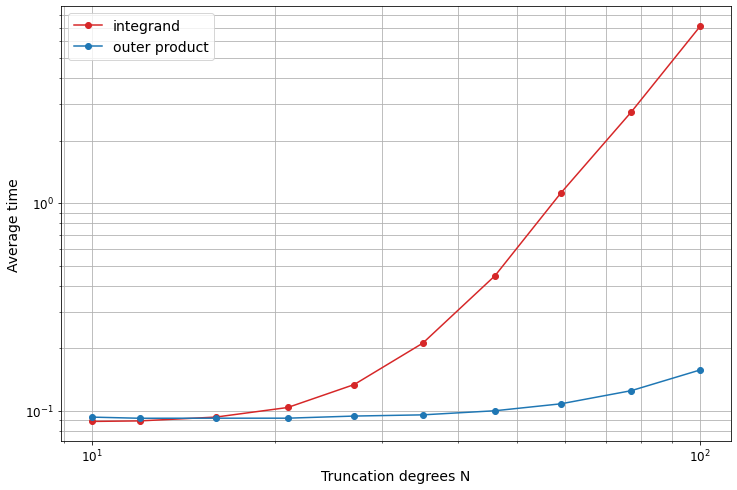

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Truncation degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

### Integrating entire matrices

In [39]:
matrix_expr_file = "./out/eigen/Malkus/Transformed/matrix_expr.json"
Ntrunc = 5

%time M_val, K_val = routine_matrix_calculation(read_from=matrix_expr_file, Ntrunc=Ntrunc, xpd_recipe=xpd_cfg.recipe, save_to=None, outer=False, verbose=0)

CPU times: total: 1.95 s
Wall time: 2.18 s


In [41]:
def params_setup(Nmax):
    return matrix_expr_file, Nmax, xpd_cfg.recipe

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda fname, Ntrunc, recipe: routine_matrix_calculation(read_from=fname, Ntrunc=Ntrunc, xpd_recipe=recipe, save_to=None, outer=False, verbose=0),
        lambda fname, Ntrunc, recipe: routine_matrix_calculation(read_from=fname, Ntrunc=Ntrunc, xpd_recipe=recipe, save_to=None, outer=True, verbose=0),
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_to_Nmax(n_range[-1], alpha, beta, xi)
    ],
    labels=["integrand", "outer product"],
    n_range=[N for N in range(5, 51, 5)],
    equality_check=lambda x, y: np.allclose(x, y, rtol=1e-12, atol=1e-12),
    show_progress=False
)

Output()

Compare the results

In [42]:
benchmarks

┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n  ┃ integrand          ┃ outer product      ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 5  │ 1.652646           │ 1.7342855000000001 │
│ 10 │ 1.6284591000000002 │ 1.8409247000000002 │
│ 15 │ 1.7544601000000002 │ 1.7317008          │
│ 20 │ 2.009061           │ 1.7326515          │
│ 25 │ 2.7371796          │ 1.7503939000000002 │
│ 30 │ 3.6698987          │ 1.8049171000000002 │
│ 35 │ 5.5097454          │ 1.9230028000000001 │
│ 40 │ 8.0336697          │ 1.8559846000000002 │
│ 45 │ 11.716146100000001 │ 2.0080449000000002 │
│ 50 │ 16.590471100000002 │ 1.9768878          │
└────┴────────────────────┴────────────────────┘

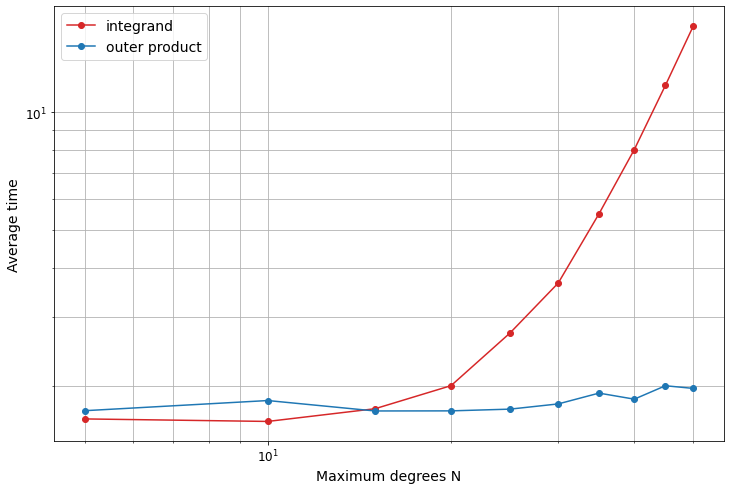

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

---
## Multi-precision libraries

The two multi-precision (arbitrary precision) libraries that can be relatively easily manipulated in Python are `mpmath` (**M**ulti-**P**recision **Math**ematics, a pure Python library) and `gmpy2` (a C-coded Python extension module, probably obtained its name as it originally only supports the **G**NU **M**ulti-**P**recision arithmetic lib).

This section provides a comparison on the efficiency of the two modules.

### Data conversion efficiency

According to the benchmarks below, converting numpy array to gmpy2 floats is more efficient by a factor of 1.4 to over 2.

In [71]:
import gmpy2 as gp
import mpmath as mp
from pg_utils.numerics.utils import to_gpmy2_f, to_mpmath_f

mp.mp.prec = 112
print(mp.mp)

ctx = gp.get_context()
ctx.precision = 112
print("gmpy2 context:\n  prec = {:d}".format(gp.get_context().precision))

Mpmath settings:
  mp.prec = 112               [default: 53]
  mp.dps = 33                 [default: 15]
  mp.trap_complex = False     [default: False]
gmpy2 context:
  prec = 112


In [89]:
rng = np.random.default_rng()

to_gp = np.vectorize(lambda x: gp.mpfr(x, 112), otypes=(object,))
to_mp = np.vectorize(lambda x: mp.mpf(x), otypes=(object,))

def params_setup(Nmax):
    return rng.normal(size=(Nmax, Nmax)), rng.normal(size=(Nmax, Nmax))

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda a, b: (to_gp(a), to_gp(b)),
        lambda a, b: (to_gpmy2_f(a, prec=112), to_gpmy2_f(b, prec=112)),
        lambda a, b: (to_mp(a), to_mp(b)),
        lambda a, b: (to_mpmath_f(a, prec=112), to_mpmath_f(b, prec=112)),
    ],
    labels=["numpy->gmpy2", "numpy->str->gmpy2", "numpy->mpmath", "numpy->str->mpmath"],
    n_range=[int(N) for N in np.logspace(1, 3, num=10)],
    equality_check=None,
    show_progress=False
)

Output()

In [90]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ numpy->gmpy2         ┃ numpy->str->gmpy2      ┃ numpy->mpmath         ┃ numpy->str->mpmath    ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10   │ 0.0003993            │ 0.00048610000000000005 │ 0.0005872000000000001 │ 0.0018348000000000001 │
│ 16   │ 0.0010359            │ 0.0012021              │ 0.0015312000000000001 │ 0.004596800000000001  │
│ 27   │ 0.0029501            │ 0.0033499000000000003  │ 0.0043302             │ 0.012906              │
│ 46   │ 0.0085295            │ 0.009686               │ 0.0127887             │ 0.0384274             │
│ 77   │ 0.023975100000000003 │ 0.0284742              │ 0.0366621             │ 0.1081976             │
│ 129  │ 0.06803300000000001  │ 0.0783147              │ 0.10596810000000001   │ 0.30719470000000004   │
│ 215  │ 0.1956246            │ 0.2228697              │ 0.5110787             │ 0.8771238             │
│ 359  │ 0.5420347            │ 0.6190638              │ 1.1925076000000001    │ 2.8297215000000002    │
│ 599  │ 1.5331517000000001   │ 1.7325427000000002     │ 3.0016545000000003    │ 7.3195033             │
│ 1000 │ 4.252029100000001    │ 4.884752300000001      │ 8.4069043             │ 20.4036958            │
└──────┴──────────────────────┴────────────────────────┴───────────────────────┴───────────────────────┘

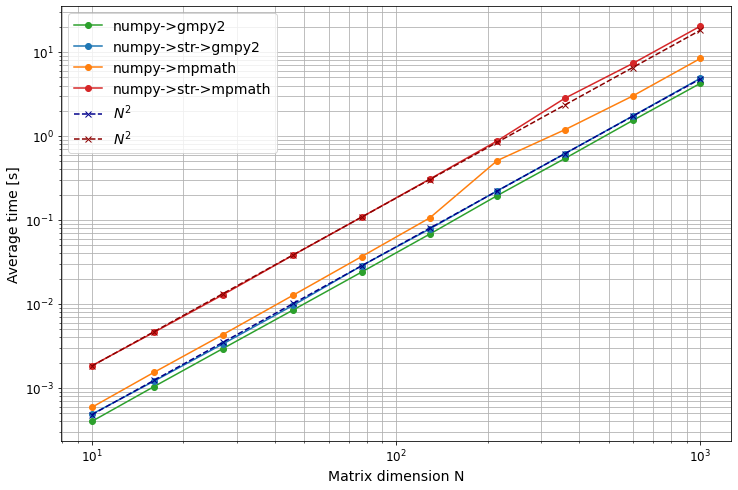

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:green", "tab:blue", "tab:orange", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/(benchmarks.n_range[-6])**2)*benchmarks.n_range**2, 'x--', color="darkblue", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[3, -6]/benchmarks.n_range[-6]**2)*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")

ax.set_xlabel("Matrix dimension N", fontsize=14)
ax.set_ylabel("Average time [s]", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Two modes of conversions are benchmarked.
1. In the first mode (orange line), the multi-precision float is directly constructed from a Python float;
2. In the second mode (red line), the multi-precision float is constructed from a string.

For `mpmath`, it turns out that the second mode is more expensive by a factor of $2\sim 3$. Unforunately, using a string is typically the only way to go if the source has higher precisions than double precision, e.g. converting from gmpy2 floats. The overhead cost in `gmpy2` however is much lower.

### Linear algebra efficiency

The speed of linear algebra is tested with the matrix-matrix multiplication (matmul).

Result shows that `gmpy2` float can be 5~6 times more efficient than `mpmath` float.
However, since neither are as optimized as double-precision float in numpy, the matmul operation follows an uninteresting $N^3$ even at moderate dimension, and can be 4 orders of magnitudes slower than numpy.

In [48]:
rng = np.random.default_rng()

def params_setup(Nmax):
    A, B = rng.normal(size=(Nmax, Nmax)), rng.normal(size=(Nmax, Nmax))
    A_gp = np.array([[gp.mpfr(A[i_r, i_c], 112) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_gp = np.array([[gp.mpfr(B[i_r, i_c], 112) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    A_mp = np.array([[mp.mpf(A[i_r, i_c]) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_mp = np.array([[mp.mpf(B[i_r, i_c]) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    return A, B, A_gp, B_gp, A_mp, B_mp

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda a1, b1, a2, b2, a3, b3: a1 @ b1,
        lambda a1, b1, a2, b2, a3, b3: a2 @ b2, 
        lambda a1, b1, a2, b2, a3, b3: a3 @ b3
    ],
    labels=["numpy", "gmpy2", "mpmath"],
    n_range=[int(N) for N in np.logspace(0.5, 2, num=10)],
    equality_check=None,
    show_progress=False
)

Output()

In [49]:
benchmarks

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n   ┃ numpy                  ┃ gmpy2                  ┃ mpmath                ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 3   │ 2.1000000000000002e-06 │ 1.25e-05               │ 6.440000000000001e-05 │
│ 4   │ 2.1000000000000002e-06 │ 2.82e-05               │ 0.0001564             │
│ 6   │ 2.2e-06                │ 9.38e-05               │ 0.0005498             │
│ 10  │ 2.4000000000000003e-06 │ 0.00044050000000000003 │ 0.0026460000000000003 │
│ 14  │ 3e-06                  │ 0.0012384000000000002  │ 0.0073844             │
│ 21  │ 6.200000000000001e-06  │ 0.0042145              │ 0.0255995             │
│ 31  │ 7.3e-06                │ 0.013646400000000001   │ 0.0831509             │
│ 46  │ 9.100000000000001e-06  │ 0.0449458              │ 0.27911040000000004   │
│ 68  │ 1.3100000000000002e-05 │ 0.145908               │ 0.9214535             │
│ 100 │ 2.16e-05               │ 0.46882250000000003    │ 3.0447109             │
└─────┴────────────────────────┴────────────────────────┴───────────────────────┘

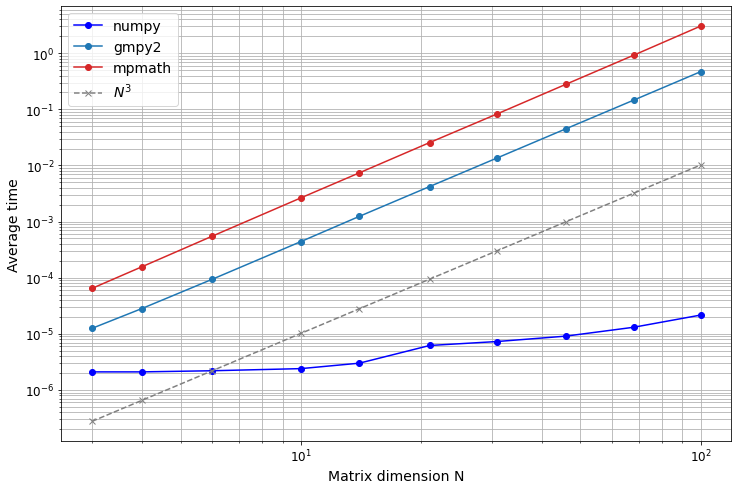

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:blue", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -8]/(benchmarks.n_range[-8])**3)*benchmarks.n_range**3, 'x--', color="gray", label=r"$N^3$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/(benchmarks.n_range[-6])**3)*benchmarks.n_range**3, 'x--', color="darkblue", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[2, -6]/benchmarks.n_range[-6]**3)*benchmarks.n_range**3, 'x--', color="darkred", label=r"$N^2$")

ax.set_xlabel("Matrix dimension N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Linear algebra is also faster in `gmpy2` compared to `mpmath`. It is however unlikely that this will become a bottleneck.

---
## Multi-precision Jacobi nodes

In [92]:
from sympy.integrals.quadrature import gauss_jacobi
from pg_utils.numerics.special import roots_jacobi_mp
import sympy
import pandas as pd

Benchmark

The multi-precision Gauss-Jacobi quadrature weights and nodes calculation via `sympy.integrals.quadrature.gauss_jacobi` is used as a benchmark.

This method is quite slow, using around 25s for the following $N$, $\alpha$, $\beta$ configuration. The double-prec version `scipy.special.roots_jacobi` is very fast.

Note that there seems to be some caching in the Jacobi evaluation for `sympy`. The second run is often a lot faster.

In [93]:
%%time
xi_sp_mp, wt_sp_mp = gauss_jacobi(100, sympy.Rational(-1,2), sympy.S.Zero, n_digits=34)
xi_np_dp, wt_np_dp = specfun.roots_jacobi(100, -0.5, 0.)

CPU times: total: 46.1 s
Wall time: 48.1 s


The sympy routine to calculate the nodes is quite slow, and I don't want to waste 20-30s on calculating one set of nodes for N=100. For reduced system, we are looking at 5 nontrivial matrix blocks, so 100-150s will be spent on calculating the nodes and weights alone. For the full system, this would exceed 700s: more than 10 minutes spent on calculating the nodes and weights alone. This is unbearable.

Instead, since the double precision algorithm is very fast (and it is fast because the roots are obtained by solving the eigenvalue problem of a banded matrix, whose elements are related to the coefficients from the recurrence relation), I want to see if I can run a Newton-Rhapson refinement using the `scipy.specials.roots_jacobi` solutions as a starting point.

In [94]:
%%time

mp.mp.prec = 112
alpha_mp, beta_mp = mp.mpf("-0.5"), mp.mpf("0.0")

roots_result = roots_jacobi_mp(100, alpha_mp, beta_mp, n_dps=33, extra_dps=8, max_iter=10)
xi_mp_newton = roots_result.xi
wt_mp = roots_result.wt

CPU times: total: 141 ms
Wall time: 235 ms


In [95]:
roots_result

Jacobi polynomial root-finding result:
Root-finding successful.
Convergence to 33 digits after 3 iters

Quite successful really... and it takes only 0.2s.

In [96]:
df_nodes = pd.DataFrame(data={
    "scipy double": xi_np_dp, 
    "sympy dps=34": xi_sp_mp, 
    "scipy + Newton refine": to_gpmy2_f(xi_mp_newton)
})
df_nodes.iloc[:5, :].transpose().style.format("{:.32f}")

,0,1,2,3,4
scipy double,-0.99971229548776008311250507176737,-0.99848441235832563478425072389655,-0.99627662205050782073811888039927,-0.99309060159914885890231062148814,-0.98892941939967404785249982523965
sympy dps=34,-0.99971229548775997116606474817077,-0.99848441235832564272967596906802,-0.99627662205050781363500407860635,-0.99309060159914881138231096452343,-0.98892941939967396311380357456058
scipy + Newton refine,-0.99971229548775997116606474817077,-0.99848441235832564272967596906802,-0.99627662205050781363500407860635,-0.99309060159914881138231096452343,-0.98892941939967396311380357456058


In [97]:
df_weights = pd.DataFrame(data={
    "scipy double": wt_np_dp, 
    "sympy dps=34": wt_sp_mp,
    "scipy + Newton refine": to_gpmy2_f(wt_mp)
})

In [98]:
df_weights.iloc[:5, :].transpose().style.format("{:.32f}")

,0,1,2,3,4
scipy double,0.00052209963862769536661195823868,0.00121522418362476187191079102234,0.00190907696669464273936389631103,0.00260255023378054171565021412960,0.00329540246467605914271192801834
sympy dps=34,0.00052209963864736080483863273355,0.00121522418362357224038327179809,0.00190907696669735644718387511154,0.00260255023377868656888681827135,0.00329540246467667222387581809540
scipy + Newton refine,0.00052209963864736080483863273355,0.00121522418362357224038327179809,0.00190907696669735644718387511154,0.00260255023377868656888681827135,0.00329540246467667222387581809540


And the accuracy is definitely enough. Since the original error is already at the order of magnitude of $10^{-14}$, and Newton-Rhapson has a quadratic convergence rate, a very limited number of refinements is necessary to push it to very high precision. Because of this property, `scipy.special.roots_jacobi` also applies one iteration of Newton-Rhapson refinement after solving the eigenvalue problem.

---
## Multi-precision Jacobi eval

In [28]:
import gmpy2 as gp
import mpmath as mp
from pg_utils.numerics.special import eval_jacobi_recur_mp
from pg_utils.numerics.utils import to_numpy_f, to_mpmath_f, to_gpmy2_f

mp.mp.prec = 112
print(mp.mp)

# ctx = gp.get_context()
# ctx.precision = 112
print("gmpy2 context:\n  prec = {:d}".format(gp.get_context().precision))

Mpmath settings:
  mp.prec = 112               [default: 53]
  mp.dps = 33                 [default: 15]
  mp.trap_complex = False     [default: False]
gmpy2 context:
  prec = 53


### Precision test

In [29]:
n_range = np.arange(-2, 101)
alpha, beta = 1/2, -1/2
xi, wt = specfun.roots_jacobi(101, alpha, beta)
N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
alpha_mp, beta_mp = mp.mpf("0.5"), mp.mpf("-0.5")
alpha_gp, beta_gp = gp.mpfr("0.5", 112), gp.mpfr("-0.5", 112)
X_mp = to_mpmath_f(X_mesh, dps=33)
X_gp = to_gpmy2_f(X_mesh, dps=33)

- Calculate using the double-precision library `scipy.special.eval_jacobi`
- Calculate using the multi-precision library `mpmath.jacobi` to 32 digits
- Calculate using the recurrence function `numerics.special.eval_jacobi_recur_mp` to 32 digits

In [30]:
Jacobi_val_scipy = specfun.eval_jacobi(N_mesh, alpha, beta, X_mesh)
Jacobi_val_recur_mp = eval_jacobi_recur_mp(N_mesh, alpha_mp, beta_mp, X_mp, backend="mpmath", dps=33)
Jacobi_val_recur_gp = eval_jacobi_recur_mp(N_mesh, alpha_gp, beta_gp, X_gp, backend="gmpy2", dps=33)
Jacobi_val_mp = np.array([[mp.jacobi(n, alpha_mp, beta_mp, x_mp) for x_mp in X_mp[0, :]] for n in n_range])

Compare the results

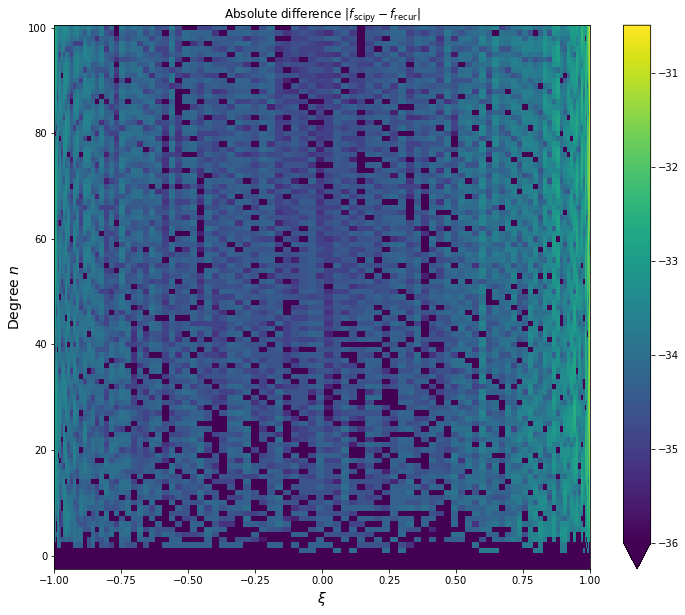

In [32]:
fig, ax = plt.subplots(figsize=(12, 10))

cmap_range = [-36, None]

# abs_err = np.abs(Jacobi_val_mp - Jacobi_val_recur_mp)
abs_err = np.abs(Jacobi_val_mp - to_mpmath_f(Jacobi_val_recur_gp, dps=33))

im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.vectorize(lambda x: float(mp.log10(x)), otypes=(np.float64,))(abs_err), *cmap_range))
ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel("Degree $n$", fontsize=14)
ax.set_title(r"Absolute difference $|f_{\mathrm{scipy}} - f_{\mathrm{recur}}|$")
plt.colorbar(im, extend="min")

plt.show()

$L_2$-error

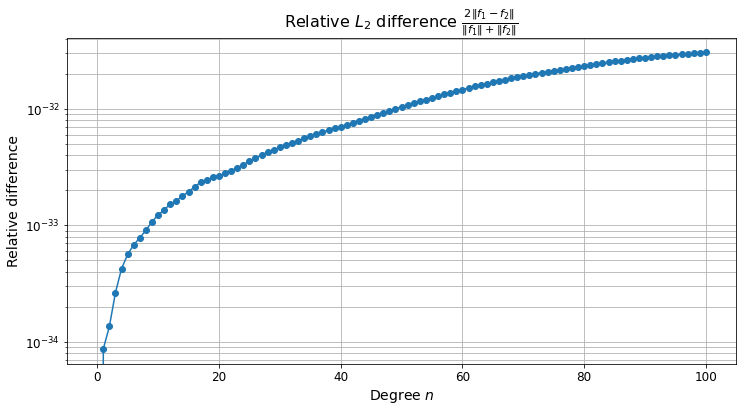

In [123]:
mp2np = np.vectorize(float, otypes=(np.float64,))

norm_Jacobi_mp = np.sum(mp2np(Jacobi_val_mp)**2*wt, axis=-1)
norm_Jacobi_recur_mp = np.sum(mp2np(Jacobi_val_recur_mp)**2*wt, axis=-1)
# norm_diff = np.sum(to_numpy_f(Jacobi_val_mp - Jacobi_val_recur_mp)**2*wt, axis=-1)
norm_diff = np.sum(to_numpy_f(Jacobi_val_mp - to_mpmath_f(Jacobi_val_recur_gp))**2*wt, axis=-1)
# norm_diff = np.sum(to_numpy_f(Jacobi_val_recur_mp - to_mpmath_f(Jacobi_val_recur_gp))**2*wt, axis=-1)

fig, ax = plt.subplots(figsize=(12, 6))

relative_err = np.sqrt(norm_diff[n_range >= 0])/((np.sqrt(norm_Jacobi_recur_mp[n_range >= 0]) + np.sqrt(norm_Jacobi_mp[n_range >= 0]))/2)
ax.semilogy(n_range[n_range >= 0], relative_err, 'o-')
ax.set_xlabel("Degree $n$", fontsize=14)
ax.set_ylabel("Relative difference", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title(r"Relative $L_2$ difference $\frac{2\Vert f_1 - f_2 \Vert}{\Vert f_1\Vert + \Vert f_2\Vert}$", fontsize=16)
ax.grid(which="both")

plt.show()

It therefore seems that what is computed using recurrence relation and what is computed using the library function is different by at most $10^{-31}$ in the relative sense.

### Efficiency test

Define functions for testing

In [130]:
from pg_utils.numerics.special import roots_jacobi_mp
import sympy

npts_eval = 101
alpha, beta = 0.5, -0.5
alpha_sp, beta_sp = sympy.Rational(1, 2), -sympy.Rational(1, 2)
alpha_mp, beta_mp = mp.mpf("0.5"), mp.mpf("-0.5")
alpha_gp, beta_gp = gp.mpfr("0.5"), gp.mpfr("-0.5")
xi, _ = specfun.roots_jacobi(npts_eval, alpha, beta)
xi_mp = roots_jacobi_mp(npts_eval, alpha_mp, beta_mp).xi
xi_gp = to_gpmy2_f(xi_mp, prec=112)

def params_setup(Nmax):
    n_range = np.arange(Nmax + 1)
    N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
    _, X_mp = np.meshgrid(n_range, xi_mp, indexing='ij')
    _, X_gp = np.meshgrid(n_range, xi_gp, indexing='ij')
    return n_range, N_mesh, X_mesh, X_mp, X_gp

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [188]:
benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp: specfun.eval_jacobi(N_mesh, alpha, beta, X_mesh),
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp: eval_jacobi_recur_mp(N_mesh, alpha_gp, beta_gp, X_gp, backend="gmpy2", dps=33),
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp: eval_jacobi_recur_mp(N_mesh, alpha_mp, beta_mp, X_mp, backend="mpmath", dps=33),
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp: np.array([[mp.jacobi(n, alpha_mp, beta_mp, x_mp) for x_mp in X_mp[0, :]] for n in N_mesh[:, 0]]),
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp: np.array([[sympy.jacobi(n, alpha_sp, beta_sp, x_tmp, evaluate=False).evalf(32) for x_tmp in X_mesh[0, :]] for n in N_mesh[:, 0]]),
    ],
    labels=["scipy", "gmpy2-recur", "mpmath-recur", "mpmath", "sympy"],
    n_range=[int(N) for N in np.logspace(1, 2.8, num=10)],
    equality_check=None,
    show_progress=False
)

Output()

Compare the results

In [189]:
benchmarks

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n   ┃ scipy               ┃ gmpy2-recur         ┃ mpmath-recur        ┃ mpmath             ┃ sympy              ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 10  │ 4.19e-05            │ 0.0021014000000000… │ 0.0242512           │ 0.151170700000000… │ 0.3992039          │
│ 15  │ 8.66e-05            │ 0.0031788000000000… │ 0.0365933           │ 0.223307600000000… │ 0.5912145000000001 │
│ 25  │ 0.0002441000000000… │ 0.0052943           │ 0.0612209           │ 0.3771315          │ 0.9646281000000001 │
│ 39  │ 0.0006237           │ 0.0083784000000000… │ 0.10363420000000001 │ 0.6179107          │ 1.5456592          │
│ 63  │ 0.0015751           │ 0.0137164           │ 0.1679092           │ 1.38459            │ 2.5712335          │
│ 100 │ 0.0036702           │ 0.0234877           │ 0.2710364           │ 1.8196775          │ 4.1932833          │
│ 158 │ 0.0084938000000000… │ 0.0401367000000000… │ 0.42037640000000004 │ 3.2163917000000004 │ 7.3281219          │
│ 251 │ 0.0196992           │ 0.0666395           │ 0.7228872000000001  │ 6.3717687000000005 │ 12.3688549         │
│ 398 │ 0.0471609000000000… │ 0.10540550000000001 │ 1.4268761           │ 13.156202500000001 │ 23.233523          │
│ 630 │ 0.11565800000000001 │ 0.1705483           │ 2.0752247           │ 27.846200000000003 │ 44.358480300000004 │
└─────┴─────────────────────┴─────────────────────┴─────────────────────┴────────────────────┴────────────────────┘

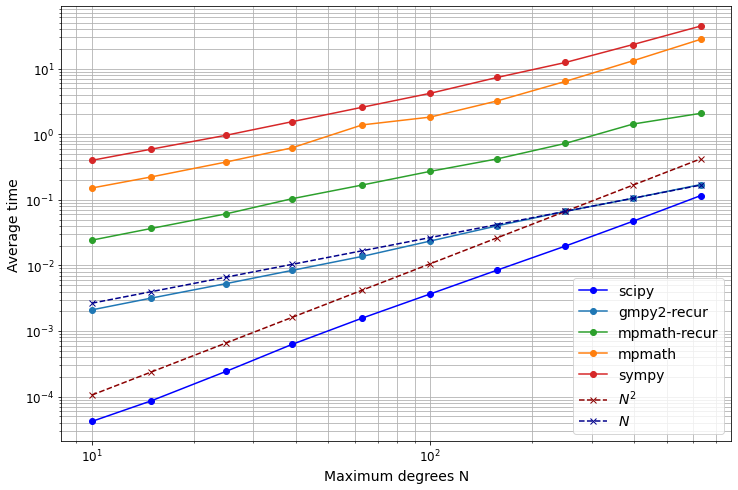

In [194]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:blue", "tab:green", "tab:orange", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[+1, -3]/(benchmarks.n_range[-3]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[+1, -3]/benchmarks.n_range[-3])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Scalings for two approaches
- Naively calling `scipy.eval_jacobi` (blue line) on an array of degrees up to degree N roughly gives a complexity of $O(N^2)$. However this trend only seems to be asymptotically true at quite large $N$ for `mpmath.jacobi` (orange) or `sympy.jacobi` (red). The scaling is less clear for the latter two.
- Using recurrence relations to generate values for the same array of degrees gives a complexity of $O(N)$.

Multi-precision evaluation with recurrence relation still hardly beats double-prec function `scipy.special.eval_jacobi`, at least at a reasonable degree. At the designed resolution ($N=50\sim 100$), a gap of two orders of magnitude or a little less is expected between the cost of quadruple-precision evaluation in `mpmath` with recurrence relation and the cost of double-precision evaluation. The other library, `gmpy2`, is more efficient, and reduces this gap to $\sim 10\times$ within this degree range. It starts to overtake the `scipy` built-in function at $N=1000$. The resolution of $N=1000$ is highly unlikely to be useful, otherwise we also need to extend the range drastically, in addition to the precision.

Among the three libraries that can do multi-precision evaluation, `gmpy2` beats `mpmath` steadily by one order of magnitude. `sympy` is the slowest, around twice as slow as `mpmath` for evaluation of Jacobian (built-in function). One could also imagine that `sympy` is even less optimized for multi-prec arithmetic, so the gap will be even wider for linear algebra operations.

Summary of the three libraries
- `sympy` is really mostly useful for symbolic manipulation. Numeric calculation is possible but slow, and there are some strange traps.
- `mpmath` is good for general-purpose multi-prec evaluation. The library functions implemented in `mpmath` far exceeds the set implemented in `gmpy2`.
- `gmpy2` is good for multi-prec basic arithmetics. The linear algebra built around `gmpy2` takes a fraction of what `mpmath` takes.

---
## Multi-precision lambdify

The second to last step: can we actually convert symbolic expressions to functions that can actually be recognized and run by these multi-precision libraries?

This section provides tests on lambdifying `sympy.Expr` with `mpmath` backend or `gmpy2` backend.

In [2]:
import gmpy2 as gp
import mpmath as mp
from pg_utils.numerics.special import eval_jacobi_recur_mp
from pg_utils.numerics.utils import to_numpy_f, to_mpmath_f, to_gpmy2_f

mp.mp.prec = 112
print(mp.mp)

# ctx = gp.get_context()
# ctx.precision = 112
print("gmpy2 context:\n  prec = {:d}".format(gp.get_context().precision))

Mpmath settings:
  mp.prec = 112               [default: 53]
  mp.dps = 33                 [default: 15]
  mp.trap_complex = False     [default: False]
gmpy2 context:
  prec = 53


For testing purpose: load some random matrix expression

In [3]:
import sympy, json
from pg_utils.pg_model import expansion as xpd
from pg_utils.numerics import matrices as nmatrix

with open("./out/eigen/Malkus/Reduced/matrix_expr.json", 'r') as f:
    matrix_obj = json.load(f)
    M_expr = xpd.SystemMatrix.deserialize(matrix_obj["M"])
    K_expr = xpd.SystemMatrix.deserialize(matrix_obj["K"])

Choose one element/operand to calculate:

In [4]:
from pg_utils.pg_model import params
from pg_utils.pg_model.expand_stream_force import recipe as xpd_recipe

par_val = {
    params.Le: sympy.Rational(1, 10000),
    xpd.m: 3
}

element = K_expr["F_ext", "Psi"].subs(par_val)
opd_calc = element._opd_B.doit()

In [10]:
opd_calc

(81*(1/2 - \xi/2)*(\xi/2 + 1/2)*jacobi(\ell, 3/2, 3, \xi) + 117*(\xi/2 + 1/2)**2*jacobi(\ell, 3/2, 3, \xi)/2 - 9*(\xi/2 + 1/2)*((1/2 - \xi/2)**(3/2)*(2*\ell + 11)*(\xi/2 + 1/2)*((2*\ell + 13)*(\xi/2 + 1/2)*jacobi(\ell - 2, 7/2, 5, \xi) + jacobi(\ell - 1, 5/2, 4, \xi)) + 6*(1/2 - \xi/2)**(3/2)*(2*\ell + 11)*(\xi/2 + 1/2)*jacobi(\ell - 1, 5/2, 4, \xi) + 6*(1/2 - \xi/2)**(3/2)*jacobi(\ell, 3/2, 3, \xi) - 6*sqrt(1/2 - \xi/2)*(2*\ell + 11)*(\xi/2 + 1/2)**2*jacobi(\ell - 1, 5/2, 4, \xi) - 18*sqrt(1/2 - \xi/2)*(\xi/2 + 1/2)*jacobi(\ell, 3/2, 3, \xi) + 3*(\xi/2 + 1/2)*(-sqrt(1/2 - \xi/2) + (\xi/2 + 1/2)/sqrt(1/2 - \xi/2))*jacobi(\ell, 3/2, 3, \xi))/sqrt(1/2 - \xi/2) - 9*(4*(1/2 - \xi/2)**(3/2)*(\ell/2 + 11/4)*(\xi/2 + 1/2)**2*jacobi(\ell - 1, 5/2, 4, \xi) + 3*(1/2 - \xi/2)**(3/2)*(\xi/2 + 1/2)*jacobi(\ell, 3/2, 3, \xi) - 3*sqrt(1/2 - \xi/2)*(\xi/2 + 1/2)**2*jacobi(\ell, 3/2, 3, \xi))/sqrt(1/2 - \xi/2) - 9*(\xi/2 + 1/2)*(4*(1/2 - \xi/2)**(3/2)*(\ell/2 + 11/4)*(\xi/2 + 1/2)**2*jacobi(\ell - 1, 5

Okay this expression is complicated enough...

Now we introduce different lambdified objects

|  Function |     Backend   |   Vectorized  |   Precision     | Jacobi evaluation | 
|-----------|---------------|---------------|-----------------|-------------------|
| `opd_func_np` | `numpy`/`scipy` | Yes     | double-precision | Individual       |
| `opd_func_mp` | `mpmath`  |       Yes     | arbitrary, dep. input + working precision | Individual |
| `opd_func_mp_elementwise` | `mpmath` | Vectorized from scalar lambdified obj | arbitrary, dep. input + working precision | Individual |
| `opd_func_mp_recur` | `mpmath`  | Yes     | arbitrary, dep. input + working precision | Recurrence |
| `opd_func_gp_recur` | `gmpy2`   | Yes     | arbitrary, dep. input + context | Recurrence |

In [5]:
from pg_utils.numerics.symparser import Gmpy2Printer

opd_func_np = sympy.lambdify((xpd.n_trial, xpd.xi), opd_calc, modules=["numpy", "scipy"])

# Lambdifying the expression as mpmath, with functions replaced by vectorized forms
opd_func_mp = sympy.lambdify(
    (xpd.n_trial, xpd.xi), 
    opd_calc, 
    modules=[
        {
            "jacobi": lambda Nmesh, a, b, zmesh: np.array([[mp.jacobi(n, a, b, z) for z in zmesh[0, :]] for n in Nmesh[:, 0]]), 
            "sqrt": np.vectorize(mp.sqrt, otypes=(object,)),
        }, 
        "mpmath"],
)

# Vectorizing the scalar mpmath function and vectorizing
opd_func_mp_scaler = sympy.lambdify((xpd.n_trial, xpd.xi), opd_calc, modules=["mpmath"])
opd_func_mp_elementwise = np.vectorize(opd_func_mp_scaler, otypes=(object,))

# Lambdifying the expression as mpmath, with Jacobi replaced by evaluator using recurrence relation, and other functions replaced by vectorized forms
opd_func_mp_recur = sympy.lambdify(
    (xpd.n_trial, xpd.xi), 
    opd_calc, 
    modules=[
        {
            "jacobi": lambda Nmesh, a, b, zmesh: eval_jacobi_recur_mp(Nmesh, a, b, zmesh, dps=32, backend="mpmath"), 
            "sqrt": np.vectorize(mp.sqrt, otypes=(object,)),
        }, 
        "mpmath"],
)

opd_func_gp_recur = sympy.lambdify(
    (xpd.n_trial, xpd.xi),
    opd_calc,
    modules=[{
        "jacobi": lambda Nmesh, a, b, zmesh: eval_jacobi_recur_mp(Nmesh, a, b, zmesh, dps=32, backend="gmpy2"),
        "sqrt": np.vectorize(gp.sqrt, otypes=(object,)),
    }],
    printer=Gmpy2Printer(settings={
        'fully_qualified_modules': False, 
        'inline': True, 
        'allow_unknown_functions': True}, prec=112)
)

### Precision test

In [6]:
n_range = np.arange(101)
alpha, beta = 1/2, -1/2
xi, wt = specfun.roots_jacobi(101, alpha, beta)

N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
X_mp = to_mpmath_f(X_mesh, dps=33)
X_gp = to_gpmy2_f(X_mesh, dps=33)

Calculate the values using different lambdified objects

In [7]:
opd_val_np = opd_func_np(N_mesh, X_mesh)
opd_val_mp = opd_func_mp(N_mesh, X_mp)
opd_val_mp_elementwise = opd_func_mp_elementwise(N_mesh, X_mp)
opd_val_mp_recur = opd_func_mp_recur(N_mesh, X_mp)
# opd_val_gp_recur = opd_func_gp_recur(N_mesh, X_gp)
with gp.local_context(gp.context(), precision=113):
    opd_val_gp_recur = opd_func_gp_recur(N_mesh, X_gp)

Difference plot

C:\Users\gentle\AppData\Local\Temp\ipykernel_20988\3655679888.py:11: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.log10(plot_diff), *cmap_range), cmap="inferno")


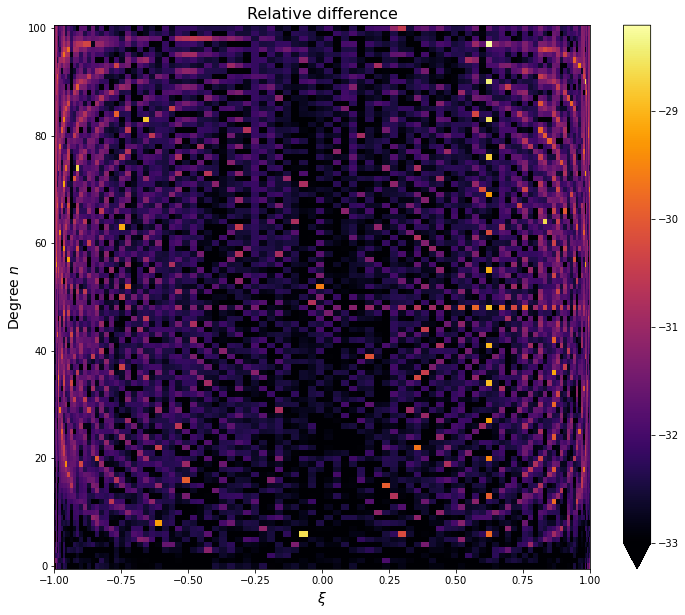

In [8]:
val_a, val_b = opd_val_mp, opd_val_gp_recur
abs_diff = np.abs(to_numpy_f(to_gpmy2_f(val_a, prec=113) - to_gpmy2_f(val_b, prec=113)))
rel_diff = abs_diff/np.abs(to_numpy_f(val_a))

fig, ax = plt.subplots(figsize=(12, 10))

cmap_range = [-33, None]
plot_type = "Relative"

plot_diff = abs_diff if plot_type.lower() == "absolute" else rel_diff
im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.log10(plot_diff), *cmap_range), cmap="inferno")
ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel("Degree $n$", fontsize=14)
ax.set_title(r"%s difference" % plot_type, fontsize=16)
plt.colorbar(im, extend="min")

plt.show()

### Efficiency test

In [10]:
def params_setup(N):
    xi, wt = specfun.roots_jacobi(N, 3/2, 3)
    N_mesh, X_mesh = np.meshgrid(np.arange(N), xi, indexing='ij')
    X_mp = to_mpmath_f(X_mesh, dps=33)
    X_gp = to_gpmy2_f(X_mesh, dps=33)
    return N_mesh, X_mesh, X_mp, X_gp

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda N_mesh, X_mesh, X_mp, X_gp: opd_func_np(N_mesh, X_mesh),
        lambda N_mesh, X_mesh, X_mp, X_gp: opd_func_gp_recur(N_mesh, X_gp),
        lambda N_mesh, X_mesh, X_mp, X_gp: opd_func_mp_recur(N_mesh, X_mp),
        lambda N_mesh, X_mesh, X_mp, X_gp: opd_func_mp(N_mesh, X_mp),
    ],
    labels=["scipy", "gmpy2-recur", "mpmath-recur", "mpmath"],
    n_range=[int(N) for N in np.logspace(0.6, 2.4, num=10)],
    equality_check=None,
    show_progress=False
)

Output()

Compare the results

In [11]:
benchmarks

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n   ┃ scipy                  ┃ gmpy2-recur           ┃ mpmath-recur         ┃ mpmath             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 3   │ 0.00022960000000000002 │ 0.0039859000000000006 │ 0.019778900000000002 │ 0.0307327          │
│ 6   │ 0.00025140000000000004 │ 0.009201              │ 0.05851990000000001  │ 0.1131317          │
│ 10  │ 0.000303               │ 0.019505500000000002  │ 0.15213600000000002  │ 0.3206451          │
│ 15  │ 0.0004618              │ 0.041838200000000006  │ 0.33709290000000003  │ 0.7291407000000001 │
│ 25  │ 0.0012326000000000001  │ 0.11094830000000001   │ 0.9054500000000001   │ 2.0126148          │
│ 39  │ 0.0040258              │ 0.2644287             │ 1.3538883000000002   │ 4.277637400000001  │
│ 63  │ 0.0154389              │ 0.6958945000000001    │ 4.256252             │ 12.3483289         │
│ 100 │ 0.0560584              │ 1.7720760000000002    │ 10.3448077           │ 32.5664357         │
│ 158 │ 0.2083537              │ 4.8770324             │ 25.2628805           │ 90.2347263         │
│ 251 │ 0.7668826000000001     │ 11.569924400000001    │ 60.742980900000006   │ 275.86204080000005 │
└─────┴────────────────────────┴───────────────────────┴──────────────────────┴────────────────────┘

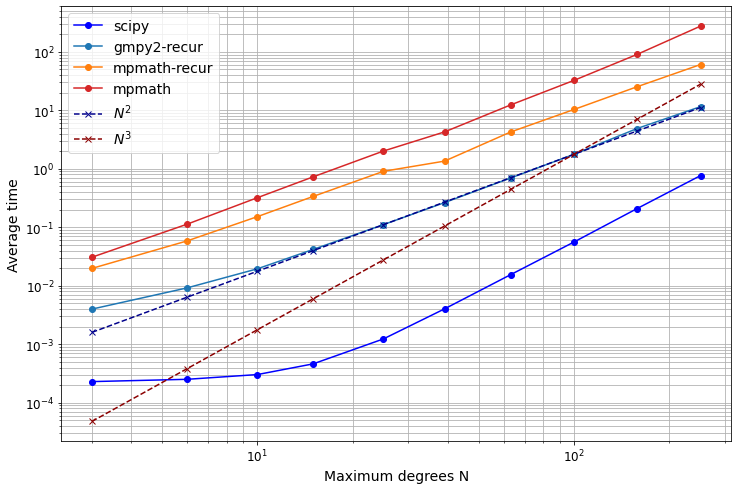

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:blue", "tab:orange", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[+1, -3]/benchmarks.n_range[-3]**2)*benchmarks.n_range**2, 'x--', color="darkblue", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[+1, -3]/benchmarks.n_range[-3]**3)*benchmarks.n_range**3, 'x--', color="darkred", label=r"$N^3$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

`gmpy2` is ~5 times faster than `mpmath` evaluation. While still much slower than `scipy` double-precision evaluation, the gap is just around 1.5 orders of magnitude for $N=100$.

---
## Multi-precision inner product matrix

Now we have all the ingredients to calculate the matrices.

In [46]:
import sympy, json, h5py, gmpy2
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import expand_stream_force as xpd_cfg
from pg_utils.numerics import matrices as nmatrix
from pg_utils.numerics import io as num_io

with open("./out/eigen/Malkus/Reduced/matrix_expr.json", 'r') as f:
    matrix_obj = json.load(f)
    M_expr = xpd.SystemMatrix.deserialize(matrix_obj["M"])
    K_expr = xpd.SystemMatrix.deserialize(matrix_obj["K"])
    par_list = [sympy.parse_expr(par) for par in matrix_obj["params"]]

with h5py.File("./out/eigen/Malkus/Reduced/matrix_m3_N50.h5", 'r') as f:
    M_val_cmp = num_io.matrix_load_from_group(f["M"]).todense()
    K_val_cmp = num_io.matrix_load_from_group(f["K"]).todense()

### Precision test

Preparing the configuration

In [48]:
from pg_utils.pg_model import params

par_val = {
    params.Le: sympy.Rational(1, 10000),
    xpd.m: sympy.Integer(3)
}

M_expr.apply(lambda ele: ele.subs(par_val), inplace=True, metadata=False)
K_expr.apply(lambda ele: ele.subs(par_val), inplace=True, metadata=False)

Ntrunc = 50
fnames = xpd_cfg.recipe.rad_xpd.fields._field_names
cnames = xpd_cfg.recipe.rad_xpd.bases._field_names
ranges_trial = [np.arange(2*Ntrunc + 1) 
    if 'M' in cname else np.arange(Ntrunc + 1) for cname in cnames]
ranges_test = [np.arange(2*Ntrunc + 1) 
    if 'M' in fname else np.arange(Ntrunc + 1) for fname in fnames]

Double-precision `scipy` evaluation

In [49]:
%%time

def eval_matrix_scipy(n_trial, n_test, verbose=False):
    quad_recipe_list = np.array([
        [nmatrix.QuadRecipe(
            init_opt={"automatic": True, "quadN": None},
            gram_opt={"backend": "scipy", "outer": True, "output": "gmpy2", "out_opt": {"dps": 33}}
        ) for ele in row] for row in M_expr._matrix
    ])
    M_val = nmatrix.MatrixExpander(M_expr, 
        quad_recipe_list, n_trial, n_test).expand(verbose=verbose)
    K_val = nmatrix.MatrixExpander(K_expr, 
        quad_recipe_list, n_trial, n_test).expand(verbose=verbose)
    return M_val, K_val

M_val_scipy, K_val_scipy = eval_matrix_scipy(ranges_trial, ranges_test, verbose=True)

Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=51
Element (F_ext, F_ext)
Integrating with alpha=0, beta=7/2, N=51
Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=51
Element (Psi, F_ext)
Integrating with alpha=3/2, beta=3, N=51
Element (F_ext, Psi)
Integrating with alpha=0, beta=7/2, N=51
CPU times: total: 1.7 s
Wall time: 817 ms


Quadruple precision (dps=33 or prec=113) `mpmath` evaluation

In [51]:
%%time

def eval_matrix_mpmath(n_trial, n_test, verbose=False):
    quad_recipe_list = np.array([
        [nmatrix.QuadRecipe(
            init_opt={"automatic": True, "quadN": None},
            gram_opt={"backend": "mpmath", "int_opt": {"n_dps": 33}, "output": "gmpy2", "out_opt": {"dps": 33}}
        ) for ele in row] for row in M_expr._matrix
    ])
    M_val = nmatrix.MatrixExpander(M_expr, 
        quad_recipe_list, n_trial, n_test).expand(verbose=verbose)
    K_val = nmatrix.MatrixExpander(K_expr, 
        quad_recipe_list, n_trial, n_test).expand(verbose=verbose)
    return M_val, K_val

M_val_mpmath, K_val_mpmath = eval_matrix_mpmath(ranges_trial, ranges_test, verbose=True)

Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=51
Element (F_ext, F_ext)
Integrating with alpha=0, beta=7/2, N=51
Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=51
Element (Psi, F_ext)
Integrating with alpha=3/2, beta=3, N=51
Element (F_ext, Psi)
Integrating with alpha=0, beta=7/2, N=51
CPU times: total: 8.78 s
Wall time: 10.1 s


In [79]:
%%time

def eval_matrix_gmpy2(n_trial, n_test, verbose=False):
    quad_recipe_list = np.array([
        [nmatrix.QuadRecipe(
            init_opt={"automatic": True, "quadN": None},
            gram_opt={"backend": "gmpy2", "int_opt": {"n_dps": 33}, "output": "gmpy2", "out_opt": {"dps": 33}}
            # gram_opt={"backend": "gmpy2", "int_opt": {"n_dps": 33}, "output": "none"}
        ) for ele in row] for row in M_expr._matrix
    ])
    M_val = nmatrix.MatrixExpander(M_expr, 
        quad_recipe_list, n_trial, n_test).expand(verbose=verbose)
    K_val = nmatrix.MatrixExpander(K_expr, 
        quad_recipe_list, n_trial, n_test).expand(verbose=verbose)
    return M_val, K_val

with gmpy2.local_context(gmpy2.context(), precision=113):
    M_val_gmpy2_2, K_val_gmpy2_2 = eval_matrix_gmpy2(ranges_trial, ranges_test, verbose=True)

Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=51
Element (F_ext, F_ext)
Integrating with alpha=0, beta=7/2, N=51
Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=51
Element (Psi, F_ext)
Integrating with alpha=3/2, beta=3, N=51
Element (F_ext, Psi)
Integrating with alpha=0, beta=7/2, N=51
CPU times: total: 2.12 s
Wall time: 2.83 s


C:\Users\gentle\AppData\Local\Temp\ipykernel_18292\3427237630.py:5: RuntimeWarning: invalid value encountered in true_divide
  rel_diff = abs_diff/np.abs(to_numpy_c(val_a))
C:\Users\gentle\AppData\Local\Temp\ipykernel_18292\3427237630.py:14: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.clip(np.log10(np.abs(to_numpy_c(val_a))), -36, None), cmap="viridis")
C:\Users\gentle\AppData\Local\Temp\ipykernel_18292\3427237630.py:22: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.clip(np.log10(plot_diff), *cmap_range), cmap="inferno")


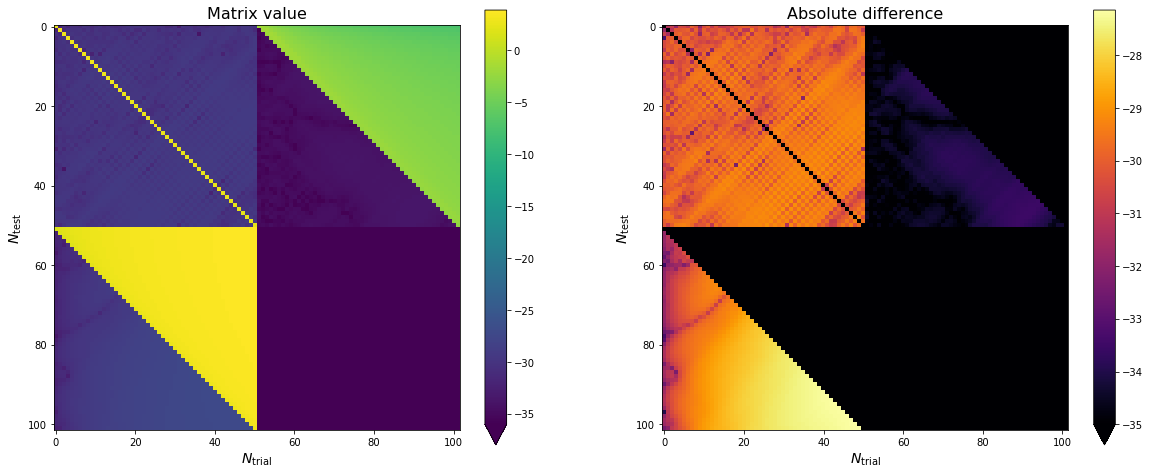

In [14]:
from pg_utils.numerics.utils import to_numpy_c, to_gpmy2_c, to_mpmath_c

val_a, val_b = K_val_gmpy2, K_val_mpmath
abs_diff = np.abs(to_numpy_c(to_gpmy2_c(val_a) - to_gpmy2_c(val_b)))
rel_diff = abs_diff/np.abs(to_numpy_c(val_a))
N_test_mesh, N_trial_mesh = np.meshgrid(np.arange(val_a.shape[0]+1), np.arange(val_a.shape[1]+1), indexing='ij')

cmap_range = [-35, None]
plot_type = "Absolute"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax = axes[0]
im = ax.imshow(np.clip(np.log10(np.abs(to_numpy_c(val_a))), -36, None), cmap="viridis")
ax.set_xlabel(r"$N_\mathrm{trial}$", fontsize=14)
ax.set_ylabel(r"$N_\mathrm{test}$", fontsize=14)
ax.set_title("Matrix value", fontsize=16)
plt.colorbar(im, extend="min", ax=ax)

ax = axes[1]
plot_diff = abs_diff if plot_type.lower() == "absolute" else rel_diff
im = ax.imshow(np.clip(np.log10(plot_diff), *cmap_range), cmap="inferno")
ax.set_xlabel(r"$N_\mathrm{trial}$", fontsize=14)
ax.set_ylabel(r"$N_\mathrm{test}$", fontsize=14)
ax.set_title(r"%s difference" % plot_type, fontsize=16)
plt.colorbar(im, extend="min", ax=ax)

plt.show()

Great! Now we can calculate the matrices in quadruple precision! The `mpmath` computation takes around 10s for $N=50$ (in the end a $102\times 102$ matrix), and the `gmpy2` computation takes around 2s. The efforts put into arbitrary-precision modules now pay off.

In [221]:
from pg_utils.numerics import io as num_io
from pg_utils.numerics import utils

K_sparse = utils.sparsify(K_val_scipy, clip_threshold=1e-8)
K_sparse_serialized = num_io.serialize_coo(K_sparse, transform=None, format="pickle")

In [219]:
K_str = json.dumps(K_sparse_serialized, indent=4)

In [253]:
np.savez("./out/tmp/mprec_np.npz", K=K_sparse_serialized)

In [257]:
with np.load("./out/tmp/mprec_np.npz", allow_pickle=True) as fread:
    myArray = fread["K"].item()
    K_sparse_reconstructed = sparse.coo_array((myArray["data"], (myArray["row"], myArray["col"])), shape=myArray["shape"])

C:\Users\gentle\miniconda3\envs\geomag\lib\site-packages\scipy\sparse\_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


### Efficiency test

In [206]:
def params_setup(Nmax):
    n_trial = [np.arange(2*Nmax + 1) 
        if 'M' in cname else np.arange(Nmax + 1) for cname in cnames]
    n_test = [np.arange(2*Nmax + 1) 
        if 'M' in fname else np.arange(Nmax + 1) for fname in fnames]
    return n_trial, n_test

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda n_trial, n_test: eval_matrix_scipy(n_trial, n_test),
        lambda n_trial, n_test: eval_matrix_gmpy2(n_trial, n_test),
        lambda n_trial, n_test: eval_matrix_mpmath(n_trial, n_test),
    ],
    labels=["scipy", "gmpy2", "mpmath"],
    n_range=[5, 10, 15, 25, 50, 75, 100, 150, 250],
    equality_check=None,
    show_progress=False
)

Output()

Compare the results

In [207]:
benchmarks

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n   ┃ scipy               ┃ gmpy2              ┃ mpmath             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 5   │ 0.34931090000000004 │ 0.4318519          │ 0.5589841          │
│ 10  │ 0.3483639           │ 0.5349599          │ 0.9358155          │
│ 15  │ 0.3561359           │ 0.6722559          │ 1.5370818000000002 │
│ 25  │ 0.37033390000000005 │ 1.0518379          │ 3.4271238000000004 │
│ 50  │ 0.46174030000000005 │ 2.8612582          │ 10.8625424         │
│ 75  │ 0.6493341           │ 6.019264300000001  │ 26.867252200000003 │
│ 100 │ 0.9606096000000001  │ 10.806909000000001 │ 51.604982400000004 │
│ 150 │ 1.6799224000000001  │ 26.4215601         │ 134.5406762        │
│ 250 │ 4.673038200000001   │ 86.7263143         │ 465.90023310000004 │
└─────┴─────────────────────┴────────────────────┴────────────────────┘

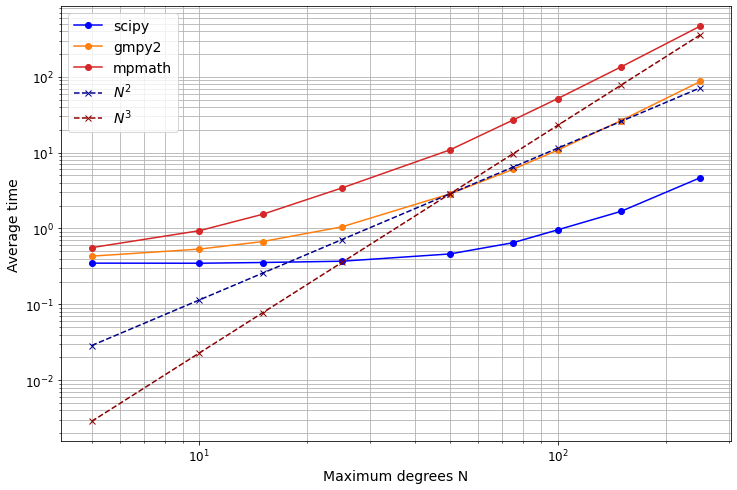

In [210]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:orange", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[+1, -5]/benchmarks.n_range[-5]**2)*benchmarks.n_range**2, 'x--', color="darkblue", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[+1, -5]/benchmarks.n_range[-5]**3)*benchmarks.n_range**3, 'x--', color="darkred", label=r"$N^3$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

The scaling for calculating the inner product matrix seems to be more complicated than other tests, since there are many processes involved.

If the evaluation of Jacobi polynomials is the most dominant process in terms of computational complexity, the scaling should be $O(N^2)$ for `gmpy2` and `mpmath` implementations which use recurrence relations, and $O(N^3)$ for `scipy` implementation which doesn't. However, $N^2$ seems to be an underestimate for `gmpy2` and `mpmath`, while $N^3$ is an overestimate for all.

Another important process is the final matrix-matrix product, which has an $O(N^3)$ scaling. However, based on previous results, even at $N=250$, the time consumed on computing the product should be around 50s for `mpmath`. This does not seem to account for all the excess time.

The general difference, as compared at $N=100$, is
- `scipy` is fastest, takes around 1s, limited to double precision.
- `gmpy2` is one order of magnitude slower, takes around 10s for quadruple precision evaluation; for the full PG/transformed system this amounts to 70s, or around 1 min.
- `mpmath` is further 5 times slower, takes around 50s for quadruple precision evaluation; for the full PG/transformed system this amounts to 350s, or around 6min.

---
## Outputing sparse matrices

Load sample matrix

In [2]:
import h5py, json, pickle
from pg_utils.numerics import io as num_io
from pg_utils.numerics import utils
import gmpy2 as gp

with h5py.File("./out/eigen/Malkus/Transformed/matrix_m3_N50.h5", 'r') as fread:
    M_val_sparse = num_io.matrix_load_from_group(fread["M"])
    K_val_sparse = num_io.matrix_load_from_group(fread["K"])

M_val_dense = M_val_sparse.toarray()
K_val_dense = K_val_sparse.toarray()

Convert to other types.

Once again note that at a scale of $1000\times 1000$, converting numpy to gmpy2 float matrices can take ~2.5s, and converting numpy to gmpy2 complex matrices can take as long as ~7s.

In [3]:
%%time
M_val_gp = utils.to_gpmy2_c(M_val_dense, prec=113)
K_val_gp = utils.to_gpmy2_c(K_val_dense, prec=113)

CPU times: total: 14.1 s
Wall time: 15.9 s


### Scipy sparse matrices

Design utilities to compare sparse matrices (for `numpy` built-in types).

In [4]:
def is_eq_sparse(array_1, array_2):
    return len((array_1 != array_2).data) == 0

def allclose_sparse(array_1, array_2, rtol=1e-5, atol=1e-8):
    c = np.abs(array_1 - array_2) - rtol * np.abs(array_2)
    return c.max() <= atol

1. HDF5

Save as hdf5 file

In [5]:
%%time
with h5py.File("./out/tmp/sparse-store_scipy_h5.h5", 'w') as fwrite:
    num_io.matrices_save_h5(fwrite.create_group("K"), K_val_sparse)
    num_io.matrices_save_h5(fwrite.create_group("M"), M_val_sparse)

CPU times: total: 31.2 ms
Wall time: 44.8 ms


Load from hdf5 object

In [6]:
%%time
with h5py.File("./out/tmp/sparse-store_scipy_h5.h5", 'r') as fread:
    K_reconstruct = num_io.matrices_load_h5(fread["K"])[0]
    M_reconstruct = num_io.matrices_load_h5(fread["M"])[0]

CPU times: total: 0 ns
Wall time: 28.2 ms


Compare: the saving and loading passed the times. No loss at all during the process.

In [7]:
print(is_eq_sparse(K_val_sparse, K_reconstruct))
print(allclose_sparse(K_val_sparse, K_reconstruct))

True
True


2. Pickle

For numpy arrays, one natural choice is to use `npy` or `npz` formats; however, pure numerical formats can already be stored using `hdf5` with very nice hierarchical structure and add-on attributes.
There will be some improvements in efficiency by using `npy` and `npz`, but this will probably not be the bottleneck here.
On the other hand, `npy` and `npz` are also not easily accessible from different programs as `hdf5` files.

To serialize arbitrary objects, however, `hdf5` cannot be used. `npy` and `npz` are also less optimized for non-numeric-array-type objects. Therefore, I use pickle.

Save as pickle file:

In [8]:
%%time
with open("./out/tmp/sparse-store_scipy_pickle.pkl", 'wb') as fwrite:
    pickle.dump(
        {"K": num_io.serialize_coo(K_val_sparse, format="pickle"), 
         "M": num_io.serialize_coo(M_val_sparse, format="pickle")},
        fwrite
    )

CPU times: total: 31.2 ms
Wall time: 24.9 ms


Load from pickle file:

In [9]:
%%time
with open("./out/tmp/sparse-store_scipy_pickle.pkl", 'rb') as fread:
    serialized_obj = pickle.load(fread)
    K_reconstruct = num_io.parse_coo(serialized_obj["K"])
    M_reconstruct = num_io.parse_coo(serialized_obj["M"])

CPU times: total: 0 ns
Wall time: 21 ms


Compare: the saving and loading passed the times. No loss at all during the process.

In [10]:
print(is_eq_sparse(K_val_sparse, K_reconstruct))
print(allclose_sparse(K_val_sparse, K_reconstruct))

True
True


3. JSON

Now I also want to have a human readable output. Candidates are: JSON, XML, YAML.

YAML and JSON are much more compact. I would use JSON here.

In [11]:
%%time
with open("./out/tmp/sparse-store_scipy_json.json", 'w') as fwrite:
    fwrite.write(json.dumps(
        {"K": num_io.serialize_coo(K_val_sparse, format="json"), 
         "M": num_io.serialize_coo(M_val_sparse, format="json")},
        cls=num_io.CompactArrayJSONEncoder, indent=2
    ))

CPU times: total: 5.84 s
Wall time: 6.79 s


In [12]:
%%time
with open("./out/tmp/sparse-store_scipy_json.json", 'r') as fread:
    serialized_obj = json.load(fread)
    K_reconstruct = num_io.parse_coo(serialized_obj["K"], transform=lambda x: np.asarray(x).astype(np.complex128))
    M_reconstruct = num_io.parse_coo(serialized_obj["M"], transform=lambda x: np.asarray(x).astype(np.complex128))

CPU times: total: 391 ms
Wall time: 619 ms


Writing a 70000-element sparse matrix takes around 5s, and the output is 6MB. Perhaps not too ideal, and now I realize it is not really human readable anyway.

Compare: the saving and loading passed the times. No loss at all during the process.

In [13]:
print(is_eq_sparse(K_val_sparse, K_reconstruct))
print(allclose_sparse(K_val_sparse, K_reconstruct))

True
True


### Gmpy2 sparse matrices

Another main reason (perhaps the greatest motive) to switch to Pickle/JSON is that you cannot store multi-prec data in `hdf5` file easily. On the other hand, the additional flexibility of `pickle` or `json` comes in handy. Let us start by converting the gmpy2 array to sparse, with a cutoff that corresponds to the double-precision cutoff:

In [4]:
from pg_utils.numerics import matrices as nmatrix

K_gp_sparse = nmatrix.sparsify(K_val_gp, clip_threshold=np.finfo(np.float64).eps)
M_gp_sparse = nmatrix.sparsify(M_val_gp, clip_threshold=np.finfo(np.float64).eps)

1. Pickle

Save as pickle file:

In [25]:
%%time
with open("./out/tmp/sparse-store_gmpy2_pickle.pkl", 'wb') as fwrite:
    pickle.dump(
        {"K": num_io.serialize_coo(K_gp_sparse, format="pickle"), 
         "M": num_io.serialize_coo(M_gp_sparse, format="pickle")},
        fwrite
    )

CPU times: total: 250 ms
Wall time: 290 ms


Load from pickle file:

In [5]:
%%time
with open("./out/tmp/sparse-store_gmpy2_pickle.pkl", 'rb') as fread:
    serialized_obj = pickle.load(fread)
    K_reconstruct = num_io.parse_coo(serialized_obj["K"])
    M_reconstruct = num_io.parse_coo(serialized_obj["M"])

CPU times: total: 93.8 ms
Wall time: 275 ms


C:\Users\gentle\miniconda3\envs\geomag\lib\site-packages\scipy\sparse\_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


Compare: the saving and loading passed the times. No loss at all during the process.
However, the sparse array with object dtype can no longer be converted to other sparse formats.
Perhaps it is necessary to use another container?

In [6]:
utils.is_eq_coo(K_gp_sparse, K_reconstruct)

True

2. JSON

Convert to JSON:

In [46]:
%%time
with open("./out/tmp/sparse-store_gmpy2_json.json", 'w') as fwrite:
    fwrite.write(json.dumps(
        {"K": num_io.serialize_coo(K_gp_sparse, format="json"), 
         "M": num_io.serialize_coo(M_gp_sparse, format="json")},
        cls=num_io.CompactArrayJSONEncoder, indent=2
    ))

CPU times: total: 3.25 s
Wall time: 4.48 s


In [7]:
%%time
with open("./out/tmp/sparse-store_gmpy2_json.json", 'r') as fread:
    serialized_obj = json.load(fread)
    K_reconstruct = num_io.parse_coo(serialized_obj["K"], transform=np.vectorize(lambda x: gp.mpc(x, precision=113), otypes=(object,)))
    M_reconstruct = num_io.parse_coo(serialized_obj["M"], transform=np.vectorize(lambda x: gp.mpc(x, precision=113), otypes=(object,)))

CPU times: total: 141 ms
Wall time: 321 ms


Compare: the saving and loading passed the times. No loss at all during the process.
However, the sparse array with object dtype can no longer be converted to other sparse formats.
Perhaps it is necessary to use another container?

In [8]:
utils.is_eq_coo(K_gp_sparse, K_reconstruct)

True

In [9]:
import pickle, json
from pg_utils.numerics import io as num_io
from pg_utils.numerics import utils

In [20]:
%%time
with open("./out/tmp/matrix_tmp.pkl", 'rb') as fread:
    serialized_obj = pickle.load(fread)
    save_meta = serialized_obj["meta"]
    cols, rows = serialized_obj["rows"], serialized_obj["cols"]
    K_reconstruct = num_io.parse_coo(serialized_obj["K"])
    M_reconstruct = num_io.parse_coo(serialized_obj["M"])

CPU times: total: 0 ns
Wall time: 48.2 ms


C:\Users\gentle\miniconda3\envs\geomag\lib\site-packages\scipy\sparse\_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


In [34]:
%%time

import gmpy2 as gp

with open("./out/tmp/matrix_tmp.json", 'r') as fread:
    serialized_obj = json.load(fread)
    save_meta = serialized_obj["meta"]
    cols, rows = serialized_obj["rows"], serialized_obj["cols"]
    K_reconstruct = num_io.parse_coo(serialized_obj["K"], transform=np.vectorize(lambda x: gp.mpc(x, precision=113), otypes=(object,)))
    M_reconstruct = num_io.parse_coo(serialized_obj["M"], transform=np.vectorize(lambda x: gp.mpc(x, precision=113), otypes=(object,)))

CPU times: total: 78.1 ms
Wall time: 172 ms


C:\Users\gentle\miniconda3\envs\geomag\lib\site-packages\scipy\sparse\_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


In [45]:
str(M_reconstruct.data[0].real)

'-0.353246753246753253385747939319116995'

In [44]:
M_reconstruct.data

array([mpc('-0.353246753246753253385747939319116995+0.0j',(113,113)),
       mpc('-2.50586008236541139511235411322352222e-35+0.0j',(113,113)),
       mpc('-2.54853052730026043165161924952468974e-34+0.0j',(113,113)),
       ...,
       mpc('5.49595036887267885053857963374903328e-35+0.0j',(113,113)),
       mpc('-8.04309969031072309436833561784248688e-35+0.0j',(113,113)),
       mpc('0.00478468899521531081803216167713799223+0.0j',(113,113))],
      dtype=object)

---
## Velocity and vorticity basis

In [42]:
from scipy.special import binom, eval_jacobi, roots_jacobi

def basis_psi(m, n, s):
    xi = 2*s**2 - 1
    return s**m*(1 - s**2)**(3/2)*eval_jacobi(n, 3/2, m, xi)

def basis_u_s(m, n, s):
    xi = 2*s**2 - 1
    return m*s**(m-1)*(1-s**2)*eval_jacobi(n, 3/2, m, xi)

def basis_u_p(m, n, s):
    xi = 2*s**2 - 1
    return s**(m-1)*(3*s**2 - m*(1-s**2))*eval_jacobi(n, 3/2, m, xi) - s**(m + 1)*(1 - s**2)*(n + m + 5/2)*eval_jacobi(n-1, 5/2, m+1, xi)

def basis_zeta(m, n, s):
    xi = 2*s**2 - 1
    return (2*(n + 1)*(2*n + 2*m + 3) + m)*s**m*eval_jacobi(n, 3/2, m, xi)

Calculate the basis functions

In [49]:
m = 3
n_array = np.array([1, 3, 5, 10])
curve_colors = ["tab:blue", "tab:green", "tab:orange", "tab:red"]
xi_array, _ = roots_jacobi(200, 3/2, m)
s_array = np.r_[0., np.sqrt((1 + xi_array)/2), 1.]

N_mesh, S_mesh = np.meshgrid(n_array, s_array, indexing='ij')

basis_val_psi = basis_psi(m, N_mesh, S_mesh)
basis_val_u_s = basis_u_s(m, N_mesh, S_mesh)
basis_val_u_p = basis_u_p(m, N_mesh, S_mesh)
basis_val_zeta = basis_zeta(m, N_mesh, S_mesh)

Plot the basis functions

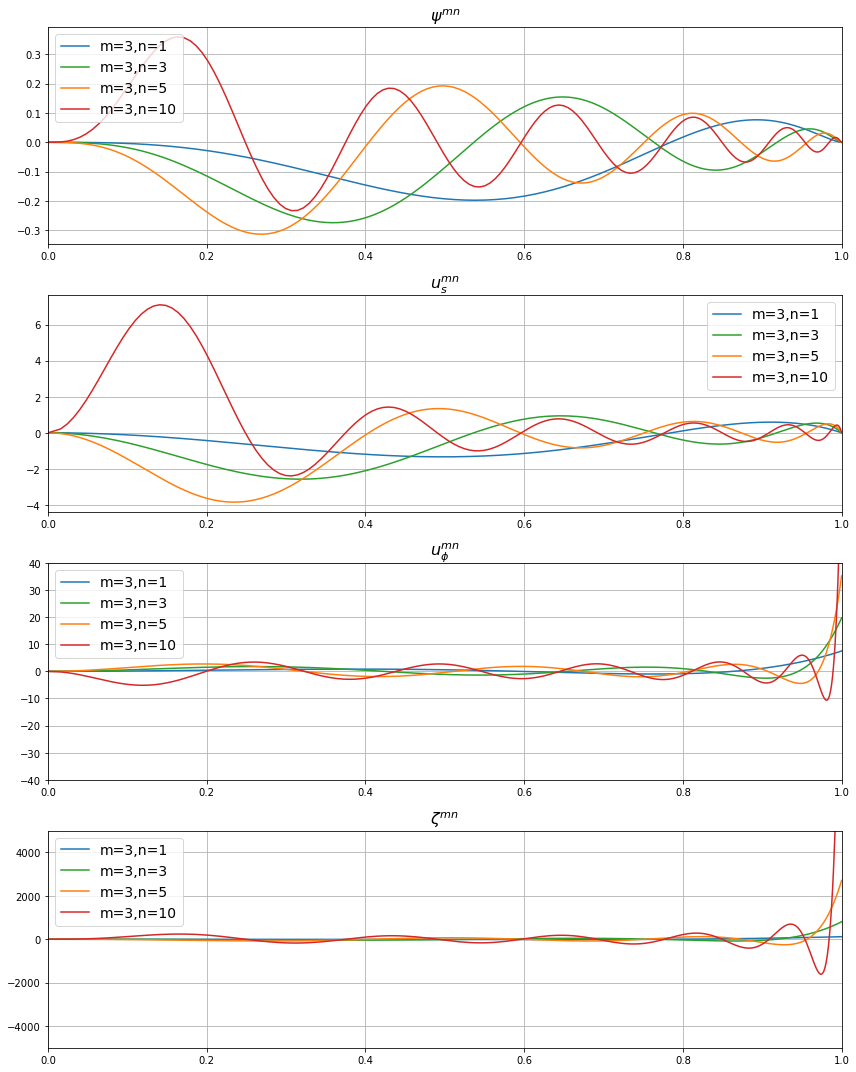

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 15))

ax = axes[0]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_psi[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$\psi^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)

ax = axes[1]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_u_s[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$u_s^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)

ax = axes[2]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_u_p[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$u_\phi^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([-40, +40])

ax = axes[3]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_zeta[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$\zeta^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([-5000, +5000])

plt.tight_layout()
plt.savefig("./out/imgs/basis_velocity_vorticity.pdf", format="pdf", bbox_inches="tight")
plt.show()

---
## Equality of arrays

In [33]:
def compare_not_ne(array_1, array_2):
    return not np.max(array_1 != array_2)

def compare_eq(array_1, array_2):
    return np.min(array_1 == array_2)

In [38]:
array_1 = np.arange(100000)
array_2 = np.arange(100000)

rng = np.random.default_rng()
array_1 = rng.normal(size=(100000))
array_1 = rng.normal(size=(100000))

print(compare_eq(array_1, array_2))
print(compare_not_ne(array_1, array_2))

False
False


Compare equal arrays

In [39]:
def params_setup(Nmax):
    return np.arange(Nmax), np.arange(Nmax)

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        compare_eq, 
        compare_not_ne
    ],
    labels=["equal", "not unequal"],
    n_range=np.logspace(1, 6, num=6).astype(int),
    show_progress=False
)

Output()

In [40]:
benchmarks

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ equal                 ┃ not unequal           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10      │ 7.9e-06               │ 8.000000000000001e-06 │
│ 100     │ 8.000000000000001e-06 │ 8.1e-06               │
│ 1000    │ 9.5e-06               │ 9.5e-06               │
│ 10000   │ 1.86e-05              │ 1.87e-05              │
│ 100000  │ 0.0001094             │ 0.0001095             │
│ 1000000 │ 0.0010902000000000002 │ 0.0010889             │
└─────────┴───────────────────────┴───────────────────────┘

Compare unequal arrays

In [41]:
def params_setup(Nmax):
    return rng.normal(size=(Nmax,)), rng.normal(size=(Nmax,))

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        compare_eq, 
        compare_not_ne
    ],
    labels=["equal", "not unequal"],
    n_range=np.logspace(1, 6, num=6).astype(int),
    show_progress=False
)

Output()

In [42]:
benchmarks

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ equal                 ┃ not unequal            ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10      │ 7.9e-06               │ 8.000000000000001e-06  │
│ 100     │ 8.000000000000001e-06 │ 8.000000000000001e-06  │
│ 1000    │ 8.7e-06               │ 8.900000000000001e-06  │
│ 10000   │ 1.16e-05              │ 1.18e-05               │
│ 100000  │ 3.99e-05              │ 3.9800000000000005e-05 │
│ 1000000 │ 0.0014167000000000001 │ 0.0014158              │
└─────────┴───────────────────────┴────────────────────────┘

Okay it seems the two approaches are basically equivalent.

## Outer product

In [2]:
def setup_vec(N):
    a = np.random.randn(N)
    b = np.random.randn(N)
    A, B = np.meshgrid(a, b, indexing='ij')
    return a, b, A, B

def test_outer(a, b, A, B):
    return np.outer(a, b)

def test_broadcast(a, b, A, B):
    return A*B

def test_broadcast2(a, b, A, B):
    return A*b

a, b, A, B = setup_vec(100)
prod_outer = test_outer(a, b, A, B)
prod_broadcast = test_broadcast(a, b, A, B)
prod_broadcast2 = test_broadcast2(a, b, A, B)

print(np.allclose(prod_outer, prod_broadcast, rtol=0., atol=0.))
print(np.allclose(prod_outer, prod_broadcast2, rtol=0., atol=0.))

True
True


In [3]:
benchmarks = perfplot.bench(
    setup=setup_vec,
    kernels=[
        test_outer, 
        test_broadcast,
        test_broadcast2
    ],
    labels=["outer", "matrix-matrix broadcast", "matrix-vector broadcast"],
    n_range=np.logspace(1, 4.2, num=15).astype(int),
    show_progress=True
)

Output()

In [4]:
benchmarks

┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n     ┃ outer                  ┃ matrix-matrix broadcast ┃ matrix-vector broadcast ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10    │ 3.6000000000000003e-06 │ 9.000000000000001e-07   │ 1.8000000000000001e-06  │
│ 16    │ 3.8e-06                │ 1.0000000000000002e-06  │ 1.9e-06                 │
│ 28    │ 4.4e-06                │ 1.3e-06                 │ 2.2e-06                 │
│ 48    │ 6e-06                  │ 1.7e-06                 │ 3e-06                   │
│ 82    │ 9e-06                  │ 2.5e-06                 │ 4.6e-06                 │
│ 138   │ 1.5e-05                │ 5.3e-06                 │ 8.900000000000001e-06   │
│ 235   │ 3.3100000000000005e-05 │ 1.3300000000000001e-05  │ 2.2100000000000002e-05  │
│ 398   │ 0.00029800000000000003 │ 0.0002973               │ 0.0002772               │
│ 673   │ 0.0008208              │ 0.0009379000000000001   │ 0.0009665               │
│ 1140  │ 0.0023299              │ 0.0028731000000000004   │ 0.0026345               │
│ 1930  │ 0.006786800000000001   │ 0.008206                │ 0.0075815000000000006   │
│ 3268  │ 0.0207964              │ 0.024451                │ 0.023161300000000003    │
│ 5531  │ 0.059724900000000004   │ 0.06896290000000001     │ 0.0734785               │
│ 9363  │ 0.14917270000000002    │ 0.224061                │ 0.1935435               │
│ 15848 │ 0.44381990000000004    │ 0.8782495               │ 1.4006243               │
└───────┴────────────────────────┴─────────────────────────┴─────────────────────────┘

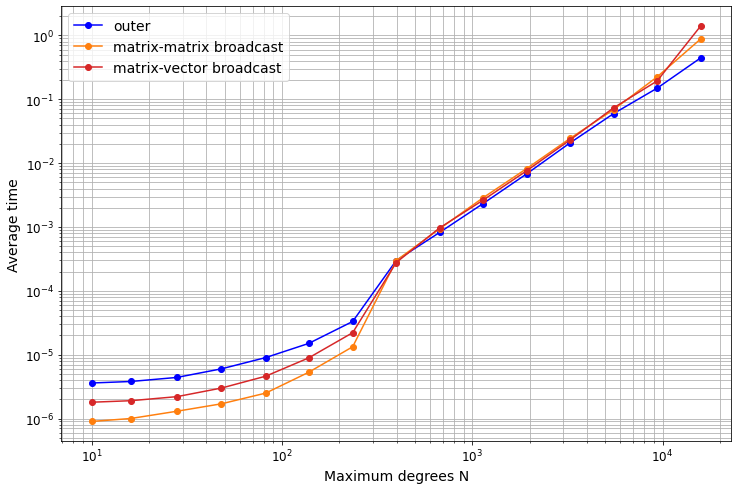

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:orange", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

## Custom function in sympy

In [2]:
import sympy as sym
import pg_utils.sympy_supp.functions as supp_f
import pg_utils.sympy_supp.simplify as supp_simplify

In [5]:
n, k1, k2 = sym.symbols('n, k_1, k_2', integer=True)
a, b, x, r, p, q = sym.symbols('a, b, x, r, p, q')
p_sh = supp_f.jacobi_polar(n, k1, k2, a, b, r)
p_sh

jacobi_polar(n, k_1, k_2, a, b, r)

In [4]:
p_sh.rewrite(sym.jacobi)

r**k_2*(1 - r**2)**(k_1/2)*jacobi(n, a, b, 2*r**2 - 1)

In [86]:
expr_test = sym.chebyshevt(n, x) + sym.chebyshevt(n-1, 2*x**2-1)**2/sym.chebyshevt(2*n, 2*x-1)
expr_test

chebyshevt(n, x) + chebyshevt(n - 1, 2*x**2 - 1)**2/chebyshevt(2*n, 2*x - 1)

In [87]:
wn, wx = map(sym.Wild, 'nx')
# expr_test.replace(sym.chebyshevt(wn, wx), sym.jacobi(wn, sym.S.Zero, sym.S.Half, wx))
expr_test.replace(sym.chebyshevt(wn, wx), supp_f.jacobi_2side(wn, k1, k2, a, b, x))

jacobi_2side(n, k_1, k_2, a, b, x) + jacobi_2side(n - 1, k_1, k_2, a, b, x)**2/jacobi_2side(2*n, k_1, k_2, a, b, x)

In [56]:
s_val = 0.99
Nmax = 100
narr = np.arange(Nmax)
terms = np.zeros(Nmax)
terms[0] = 1
terms[1] = -1/2*s_val**2
for n in range(2, Nmax):
    terms[n] = terms[n-1]*(2*n-3)/(2*n)*s_val**2
terms_flipped = np.flip(terms)
series = np.cumsum(terms_flipped)
series = np.r_[series[-1] - np.flip(series[:-1]), series[-1]]

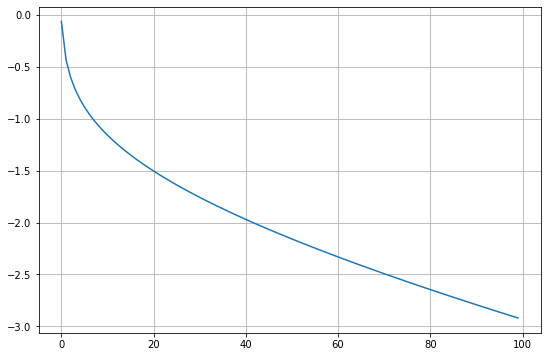

In [57]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(narr, np.log10(series - np.sqrt(1 - s_val**2)))
# ax.hlines([np.sqrt(1 - s_val**2),], 0, Nmax, colors=['k'])
ax.grid(which='both')
plt.show()